# Fake Tweets with BOW-&-Stopword

In [3]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

from spellchecker import SpellChecker

In [4]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [5]:
train.shape

(7613, 5)

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [9]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [10]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

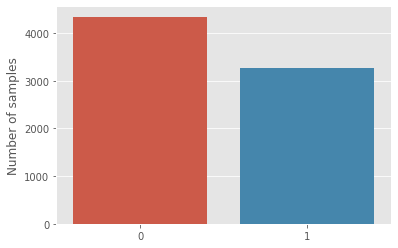

In [11]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

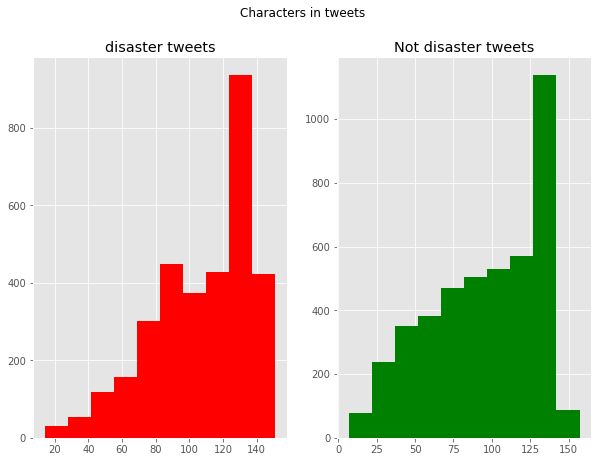

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

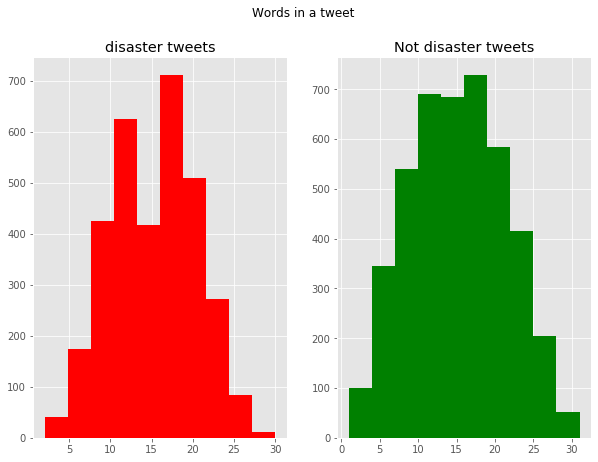

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

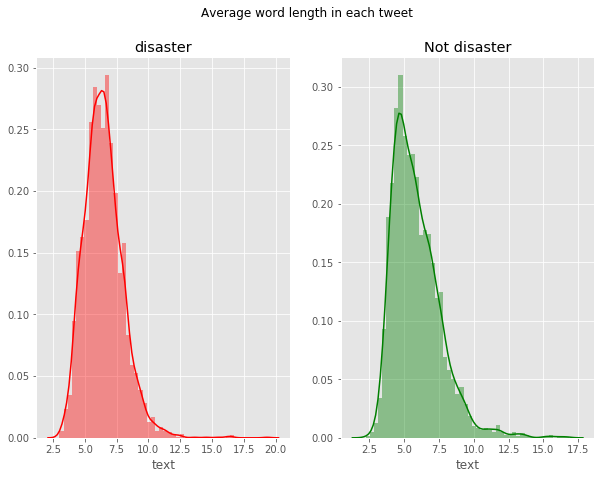

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [15]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [16]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [18]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
California, USA
New York, NY
Florida


In [19]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [20]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [21]:
corpus = create_corpus(1)

In [22]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

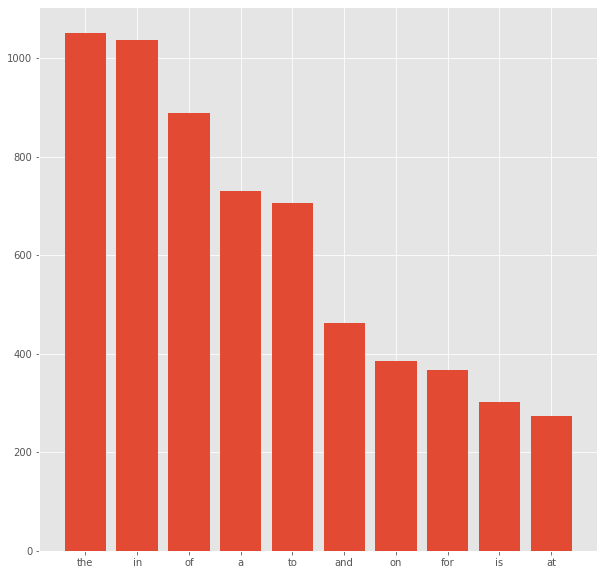

In [23]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

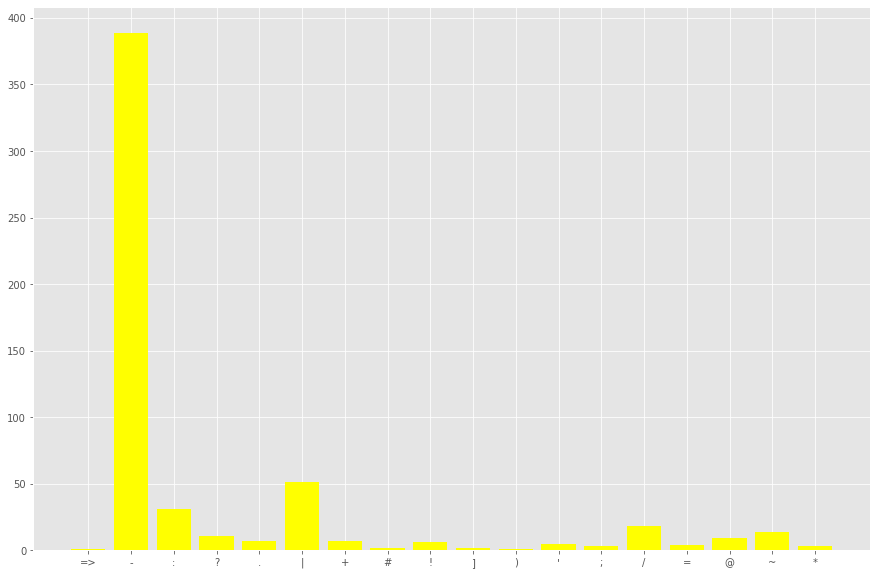

In [24]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

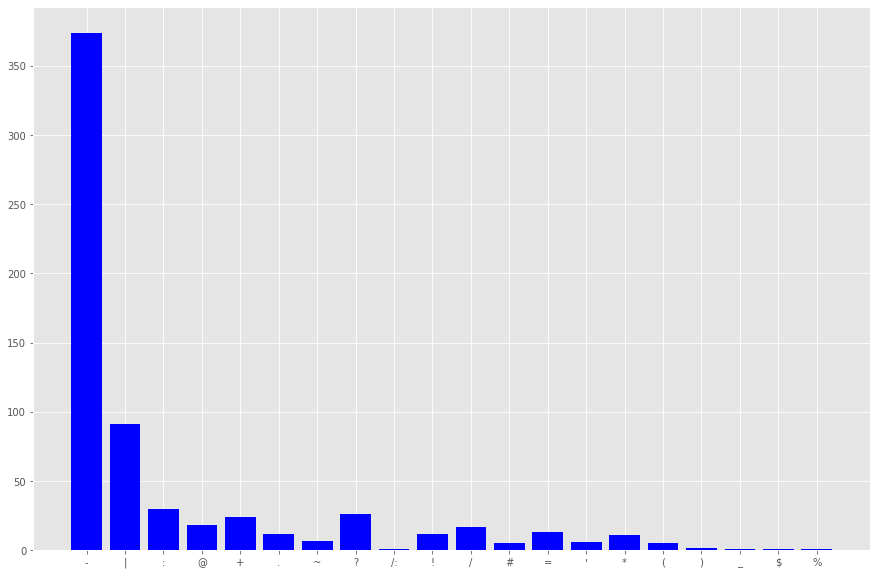

In [25]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [26]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

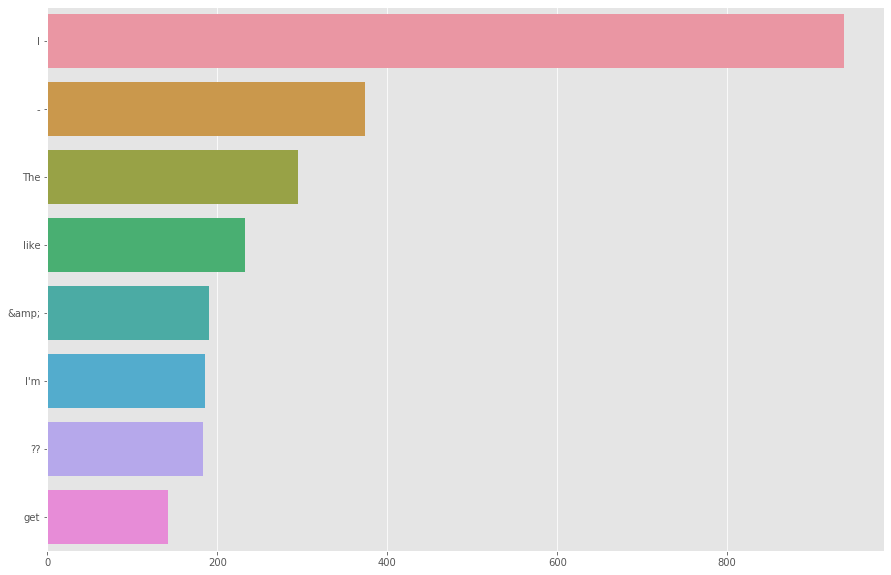

In [27]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [28]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [29]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [30]:
df_new.shape

(10876, 5)

In [31]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
text           0
target      3263
dtype: int64

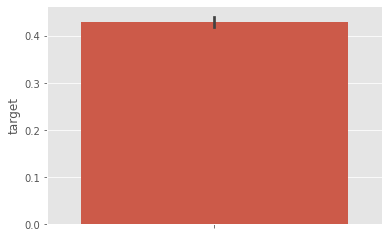

In [32]:
sns.barplot(y = 'target' , data = df_new)

In [33]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1.0
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1.0


In [34]:
df_new.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [35]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [36]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [37]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing Stopwords

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
    
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()]) 

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        train[col][ind] = string

In [40]:
for index , row in train.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [41]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [42]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
             
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()])

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        test[col][ind] = string

In [43]:
for index , row in test.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [44]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Removing URLS

In [45]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [46]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

In [47]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [48]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Remove HTML tags

In [49]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [50]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

In [51]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [52]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Remove Emoji's

In [53]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [54]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [55]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [56]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [57]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Remove Punctuations

In [58]:
def remove_punct(text):
    table=str.maketrans('','' , string.punctuation)
    return text.translate(table)

In [59]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [60]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [61]:
train['text'][12]

'raining flooding florida tampabay tampa days ive lost count '

In [62]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask canada,1
2,5,No keyword,NaN,residents asked shelter place notified officer...,1
3,6,No keyword,NaN,people receive wildfires evacuation orders ca...,1
4,7,No keyword,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [63]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


### Spelling corrections

In [64]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [65]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [66]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,No keyword,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,No keyword,NaN,m utckm volcano hawaii,1
7611,10872,No keyword,NaN,police investigating ebike collided car little...,1
7612,10873,No keyword,NaN,latest homes razed northern california wildfir...,1


In [67]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


## Convert Text to BOW

In [68]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [69]:
x

,id,text
0,1,deeds reason earthquake may allah forgive us
1,4,forest fire near la ronge sask canada
2,5,residents asked shelter place notified officer...
3,6,people receive wildfires evacuation orders ca...
4,7,got sent photo ruby alaska smoke wildfires pou...
...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...
7609,10870,ariaahrary thetawniest control wild fires cali...
7610,10871,m utckm volcano hawaii
7611,10872,police investigating ebike collided car little...


In [70]:
test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse last hurricane cityampothers ha...
3260,10868,NaN,NaN,green line derailment chicago
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo


In [71]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills china taiwan
...,...,...
3258,10861,earthquake safety los angeles ûò safety faste...
3259,10865,storm ri worse last hurricane cityampothers ha...
3260,10868,green line derailment chicago
3261,10874,meg issues hazardous weather outlook hwo


In [72]:
final_test.shape

(3263, 2)

In [73]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [74]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### BOW on Text


In [75]:
count_vect = CountVectorizer()
X_train_BOW = count_vect.fit_transform(x_train['text'])
X_test_BOW = count_vect.transform(x_test['text'])
test_BOW = count_vect.transform(test['text'])

In [76]:
print("**Bow Vectorizer**")
print("="*50)


print(X_train_BOW.shape)
print(X_test_BOW.shape)
print(test_BOW.shape)

**Bow Vectorizer**
(6090, 14754)
(1523, 14754)
(3263, 14754)


In [77]:
X_train_BOW

<6090x14754 sparse matrix of type '<class 'numpy.int64'>'
	with 54638 stored elements in Compressed Sparse Row format>

In [78]:
test_BOW

<3263x14754 sparse matrix of type '<class 'numpy.int64'>'
	with 24501 stored elements in Compressed Sparse Row format>

## Apply DIfferent ML model on BOW

## Logistic Regression on BOW

In [76]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)
Test = sc.transform(test_BOW)

In [77]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


In [78]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [79]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

77.93827971109653


***Test Data Report***
Best C =  0.0001
AUC =  74.30246570263255


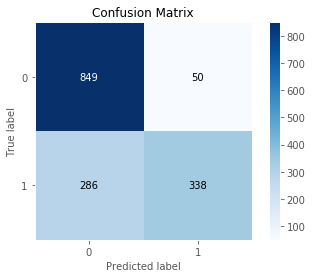

In [80]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [81]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

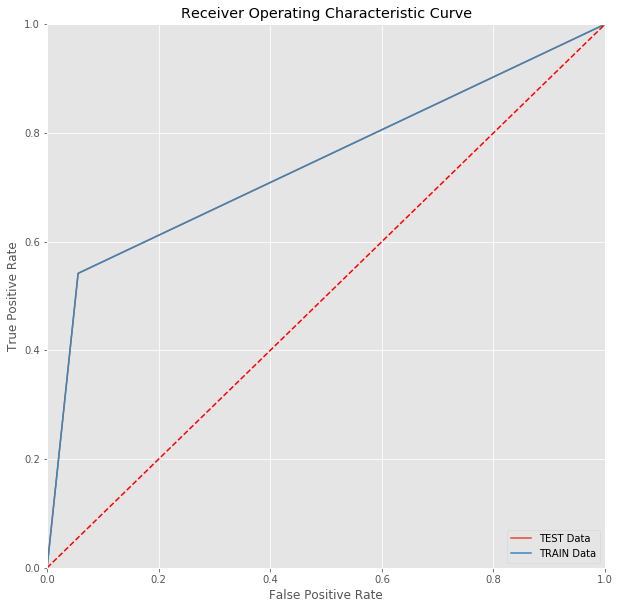

In [82]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [83]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [84]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
hiroshima	-->	0.022480
california	-->	0.022229
suicide	-->	0.019256
wildfire	-->	0.019219
killed	-->	0.018778
fires	-->	0.018581
fire	-->	0.018190
mh	-->	0.017809
bombing	-->	0.017311
northern	-->	0.016043
homes	-->	0.015721
atomic	-->	0.015571
bomber	-->	0.014582
news	-->	0.014506
pm	-->	0.014470
confirmed	-->	0.014444
debris	-->	0.014340
train	-->	0.014324
outbreak	-->	0.014170


In [85]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [86]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
im	 -->	-0.015897  
body	 -->	-0.012623  
love	 -->	-0.011817  
like	 -->	-0.010632  
full	 -->	-0.010455  
harm	 -->	-0.010029  
panic	 -->	-0.009949  
ruin	 -->	-0.009905  
bags	 -->	-0.009877  
blazing	 -->	-0.009416  
lol	 -->	-0.009397  
wrecked	 -->	-0.009266  
nowplaying	 -->	-0.009136  
youtube	 -->	-0.008944  
electrocute	 -->	-0.008876  
new	 -->	-0.008820  
hes	 -->	-0.008747  
know	 -->	-0.008704  
traumatised	 -->	-0.008666  
screamed	 -->	-0.008665  


In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on BOW

In [87]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

66.77609980302034


In [88]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [89]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007393      0.002571         0.438062        0.036750   
1       0.005409      0.003084         0.463702        0.006890   
2       0.005735      0.001243         0.515140        0.103018   
3       0.006685      0.003230         0.621918        0.092127   
4       0.004423      0.003410         0.449122        0.086939   

  param_n_neighbors               params  split0_test_score  \
0                 2   {'n_neighbors': 2}           0.667488   
1                 4   {'n_neighbors': 4}           0.635468   
2                 6   {'n_neighbors': 6}           0.625616   
3                 8   {'n_neighbors': 8}           0.614122   
4                10  {'n_neighbors': 10}           0.613300   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.655172           0.642857           0.657635  ...   
1           0.637110           0.617406           0.643678  ...   
2           0.637

In [90]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007393,0.002571,0.438062,0.036750,2,{'n_neighbors': 2},0.667488,0.655172,0.642857,0.657635,...,0.652874,0.009775,1,0.727833,0.731938,0.732964,0.731322,0.729680,0.730747,0.001805
1,0.005409,0.003084,0.463702,0.006890,4,{'n_neighbors': 4},0.635468,0.637110,0.617406,0.643678,...,0.631199,0.009775,2,0.655378,0.664409,0.661535,0.659688,0.662151,0.660632,0.003029
2,0.005735,0.001243,0.515140,0.103018,6,{'n_neighbors': 6},0.625616,0.637110,0.609195,0.621511,...,0.621839,0.009427,3,0.629721,0.661946,0.636289,0.628079,0.635057,0.638218,0.012262
3,0.006685,0.003230,0.621918,0.092127,8,{'n_neighbors': 8},0.614122,0.626437,0.606732,0.622332,...,0.616092,0.007281,4,0.616995,0.637110,0.623358,0.628284,0.624179,0.625985,0.006634
4,0.004423,0.003410,0.449122,0.086939,10,{'n_neighbors': 10},0.613300,0.621511,0.605090,0.614943,...,0.612315,0.005930,5,0.616585,0.626642,0.622332,0.617611,0.616995,0.620033,0.003897


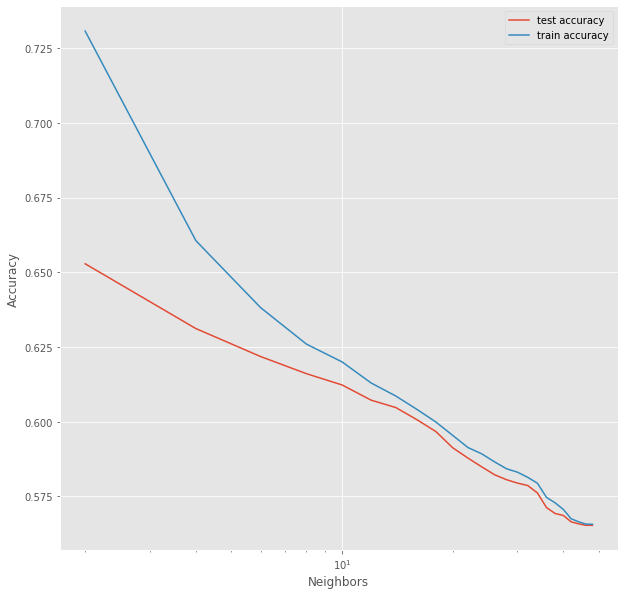

In [91]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [92]:
knn = KNeighborsClassifier(n_neighbors = 12 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\sklearn\neighbors\_base.py:413: UserWarning:

cannot use tree with sparse input: using brute force



After Cross-validation:  66.77609980302034


## Naive-Bayes on BOW

In [93]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00, 11.06it/s]


In [94]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 531.441.


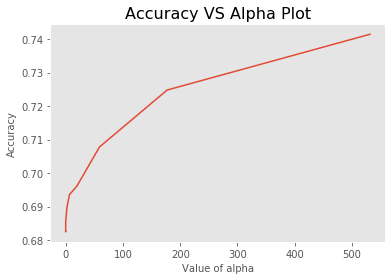


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [68.251 68.241 68.279 68.399 68.519 68.608 68.671 68.971 69.353 69.611
 70.778 72.479 74.145]


In [95]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [96]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  77.34734077478662
f1_score =  76.61229335150574
precision_score =  76.58120022904863
recall_score =  76.6451684207524


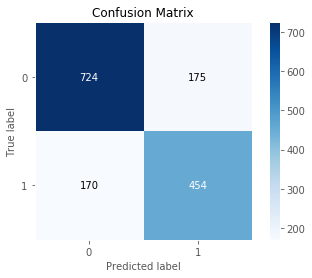

In [97]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [98]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       899
           1       0.72      0.73      0.72       624

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



## SVM on BOW

In [99]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

76.95338148391333


In [100]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.335728,1.187039,1.357456,0.190202,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,6.319104,1.092515,1.335328,0.227767,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,7.179263,0.477149,1.702584,0.135507,1,{'C': 1},0.725780,0.686371,0.737274,0.731527,...,0.714943,0.020766,4,0.971059,0.969212,0.969622,0.968391,0.969417,0.969540,0.000867
3,5.642672,0.660123,1.176653,0.347934,10,{'C': 10},0.746305,0.729885,0.779967,0.769294,...,0.755008,0.017682,1,0.988916,0.989122,0.988300,0.986658,0.987890,0.988177,0.000877
4,9.606622,0.776610,2.189726,0.259298,100,{'C': 100},0.744663,0.719212,0.767652,0.755337,...,0.744335,0.016654,2,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790
5,10.217287,1.034300,1.513727,0.295693,1000,{'C': 1000},0.739737,0.720854,0.763547,0.751232,...,0.741708,0.014692,3,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790


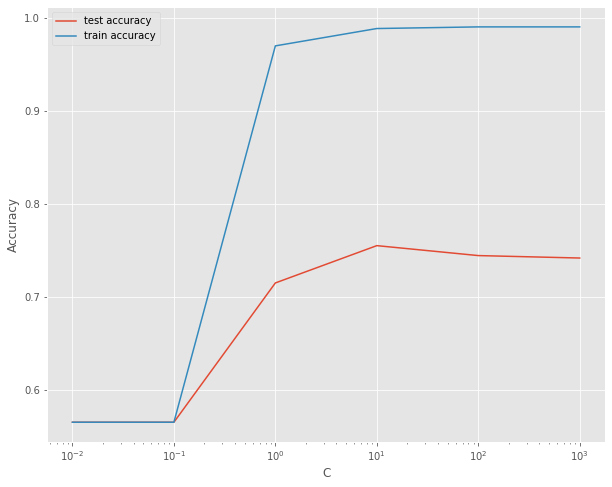

In [101]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [102]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.297963,1.627152,2.223985,0.260660,1,{'gamma': 1},0.628079,0.606732,0.630542,0.642857,...,0.622660,0.014573,4,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790
1,12.937048,0.626706,2.795922,0.102892,0.1,{'gamma': 0.1},0.628079,0.606732,0.630542,0.642857,...,0.622660,0.014573,4,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790
2,7.350183,0.294349,2.052928,0.512859,0.01,{'gamma': 0.01},0.628079,0.607553,0.632184,0.643678,...,0.623317,0.014809,3,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790
3,9.196996,1.004019,2.087679,0.352407,0.001,{'gamma': 0.001},0.639573,0.619048,0.659278,0.655993,...,0.637767,0.018273,2,0.988300,0.988916,0.988095,0.986043,0.987274,0.987726,0.000992
4,6.902229,0.621645,1.314106,0.268887,0.0001,{'gamma': 0.0001},0.711002,0.669951,0.722496,0.720033,...,0.701970,0.020483,1,0.978243,0.977217,0.976806,0.974959,0.977011,0.976847,0.001066


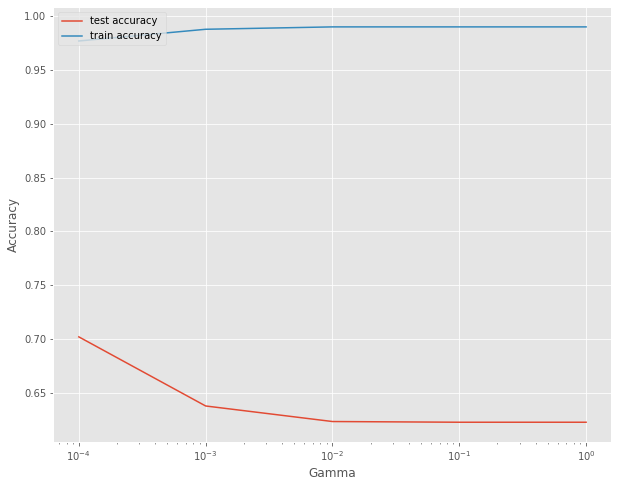

In [103]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [104]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 0.0001}


In [105]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

76.23112278397899


In [106]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


In [107]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.000.


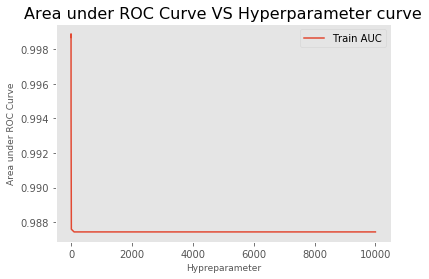

In [108]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.0001
AUC =  72.68305595961324


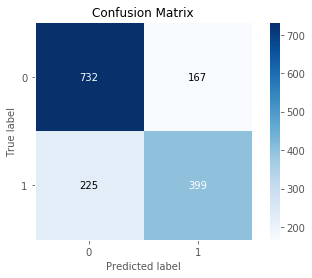

In [109]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on BOW

In [110]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

75.96848325673014


In [111]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.143830,0.058377,0.002068,0.003213,20,{'min_samples_split': 20},0.764368,0.765189,0.746305,0.771757,...,0.759606,0.009622,1,0.934524,0.934729,0.930829,0.931650,0.934524,0.933251,0.001664
1,2.028893,0.072546,0.005030,0.004112,40,{'min_samples_split': 40},0.760263,0.755337,0.743842,0.767652,...,0.755829,0.007970,2,0.909072,0.904146,0.909072,0.905993,0.904762,0.906609,0.002097
2,2.005279,0.048885,0.000405,0.000811,60,{'min_samples_split': 60},0.766010,0.752053,0.738916,0.768473,...,0.754844,0.011035,8,0.897989,0.896346,0.900041,0.892036,0.892857,0.895854,0.003029
3,1.975912,0.074137,0.007239,0.003730,80,{'min_samples_split': 80},0.761084,0.752053,0.739737,0.767652,...,0.754680,0.009410,9,0.887110,0.888752,0.893678,0.886905,0.889778,0.889245,0.002458
4,1.963692,0.060185,0.004436,0.003906,100,{'min_samples_split': 100},0.761084,0.752053,0.739737,0.769294,...,0.755008,0.009874,4,0.884647,0.888547,0.890599,0.886494,0.887726,0.887603,0.001993
5,1.990204,0.061198,0.003232,0.003506,120,{'min_samples_split': 120},0.761084,0.751232,0.739737,0.769294,...,0.754844,0.009929,5,0.883621,0.884442,0.889368,0.884852,0.886905,0.885837,0.002071
6,1.975071,0.060246,0.000000,0.000000,140,{'min_samples_split': 140},0.761084,0.753695,0.739737,0.769294,...,0.755337,0.009797,3,0.883210,0.881773,0.888957,0.884852,0.886905,0.885140,0.002562
7,1.991479,0.061998,0.002417,0.002952,160,{'min_samples_split': 160},0.761084,0.752874,0.738916,0.769294,...,0.754844,0.010130,5,0.883210,0.880952,0.886289,0.884236,0.884031,0.883744,0.001725
8,1.820568,0.294564,0.004029,0.004928,180,{'min_samples_split': 180},0.761084,0.752874,0.738916,0.769294,...,0.754844,0.010130,5,0.883210,0.880952,0.886289,0.884236,0.882389,0.883415,0.001794


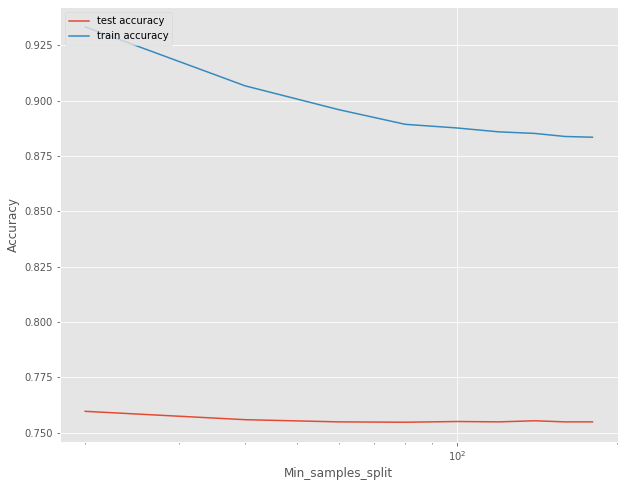

In [112]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [113]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.910472,0.057834,0.005642,0.004664,1,{'min_samples_leaf': 1},0.765189,0.760263,0.752053,0.753695,...,0.754680,0.007813,11,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
1,2.434517,0.095746,0.000000,0.000000,2,{'min_samples_leaf': 2},0.758621,0.751232,0.741379,0.761905,...,0.751067,0.008331,13,0.873563,0.874179,0.870690,0.871305,0.874179,0.872783,0.001488
2,1.743612,0.081085,0.003615,0.004474,3,{'min_samples_leaf': 3},0.759442,0.785714,0.760263,0.747947,...,0.759606,0.014431,5,0.846059,0.842159,0.841338,0.841749,0.842570,0.842775,0.001693
3,1.550806,0.086471,0.003618,0.004478,4,{'min_samples_leaf': 4},0.769294,0.773399,0.756979,0.766831,...,0.763711,0.007950,4,0.822865,0.821634,0.824507,0.824918,0.825534,0.823892,0.001434
4,1.266847,0.068047,0.004022,0.003356,5,{'min_samples_leaf': 5},0.766831,0.767652,0.765189,0.779967,...,0.767652,0.006928,1,0.812603,0.812603,0.812192,0.813834,0.815066,0.813259,0.001058
5,1.207759,0.021682,0.000404,0.000808,6,{'min_samples_leaf': 6},0.774220,0.762726,0.759442,0.772578,...,0.766338,0.005911,2,0.801724,0.802340,0.806445,0.799877,0.805213,0.803120,0.002388
6,1.116749,0.030767,0.003629,0.004494,7,{'min_samples_leaf': 7},0.771757,0.756979,0.752874,0.772578,...,0.764860,0.008253,3,0.797619,0.799261,0.801108,0.792282,0.801108,0.798276,0.003267
7,1.162546,0.064940,0.002012,0.003111,8,{'min_samples_leaf': 8},0.761084,0.756979,0.751232,0.758621,...,0.757800,0.003635,8,0.789204,0.795361,0.796388,0.787767,0.793514,0.792447,0.003394
8,1.324156,0.092891,0.002017,0.004018,9,{'min_samples_leaf': 9},0.757800,0.759442,0.751232,0.757800,...,0.757800,0.003744,9,0.788383,0.791461,0.792488,0.785714,0.791256,0.789860,0.002481
9,1.084366,0.039815,0.000000,0.000000,10,{'min_samples_leaf': 10},0.761084,0.752874,0.744663,0.767652,...,0.758456,0.008602,7,0.786125,0.786330,0.789204,0.783662,0.787562,0.786576,0.001824


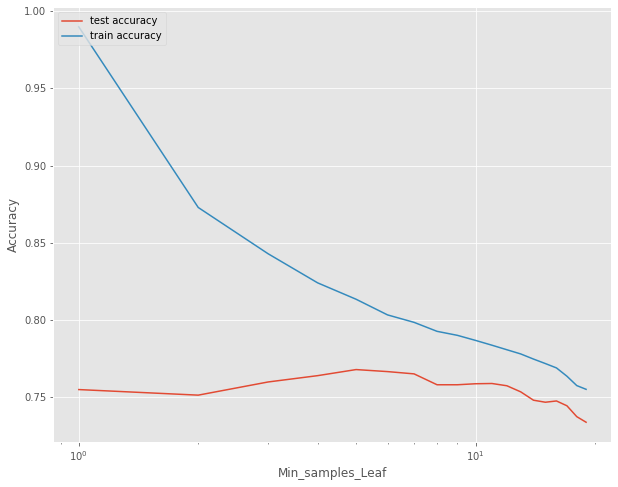

In [114]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [115]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.134180,0.011949,0.000815,0.000998,1,{'max_depth': 1},0.581281,0.581281,0.574713,0.579639,...,0.578325,0.003010,19,0.578612,0.578612,0.579639,0.579023,0.580255,0.579228,0.000636
1,0.137871,0.005019,0.000000,0.000000,2,{'max_depth': 2},0.597701,0.591954,0.587849,0.594417,...,0.591297,0.004656,18,0.591338,0.590928,0.593801,0.591954,0.594622,0.592529,0.001436
2,0.137692,0.004671,0.002011,0.003109,3,{'max_depth': 3},0.612479,0.607553,0.596059,0.600164,...,0.601314,0.007919,17,0.602627,0.603859,0.606527,0.603038,0.608169,0.604844,0.002146
3,0.148328,0.010747,0.002012,0.003112,4,{'max_depth': 4},0.622332,0.615764,0.603448,0.617406,...,0.611823,0.008523,16,0.612890,0.614327,0.617816,0.613506,0.618227,0.615353,0.002230
4,0.162220,0.001451,0.000000,0.000000,5,{'max_depth': 5},0.633005,0.624795,0.611658,0.631363,...,0.622660,0.009077,15,0.621921,0.623974,0.631568,0.622537,0.626642,0.625328,0.003518
5,0.166034,0.004563,0.000061,0.000087,6,{'max_depth': 6},0.627258,0.635468,0.620690,0.639573,...,0.629392,0.007074,14,0.630747,0.635878,0.639984,0.634852,0.637726,0.635837,0.003087
6,0.165747,0.007386,0.001606,0.003212,7,{'max_depth': 7},0.634647,0.640394,0.628900,0.641215,...,0.634483,0.005721,13,0.638752,0.644294,0.647578,0.641626,0.644089,0.643268,0.002946
7,0.184266,0.006822,0.001637,0.003274,8,{'max_depth': 8},0.651067,0.641215,0.633826,0.644499,...,0.641544,0.005979,12,0.649425,0.651683,0.656199,0.647578,0.651067,0.651190,0.002881
8,0.195995,0.010419,0.000000,0.000000,9,{'max_depth': 9},0.651067,0.645320,0.637110,0.651888,...,0.644171,0.006842,11,0.656814,0.658251,0.663383,0.654967,0.652504,0.657184,0.003647
9,0.195369,0.006650,0.000000,0.000000,10,{'max_depth': 10},0.655993,0.651067,0.642857,0.656814,...,0.650575,0.005436,10,0.662356,0.663998,0.669540,0.663588,0.660304,0.663957,0.003073


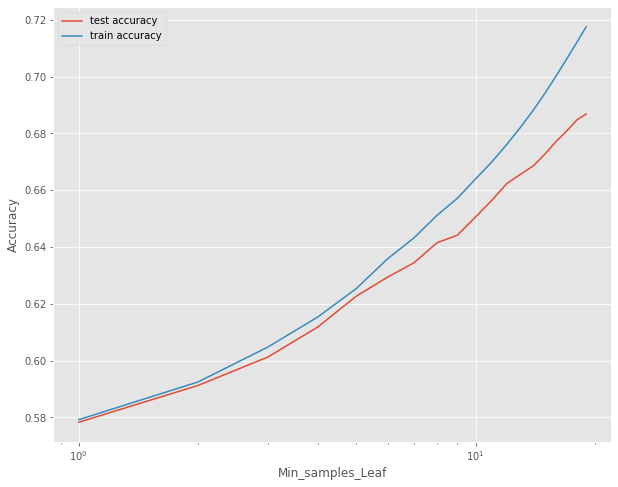

In [116]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [117]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 20}
{'min_samples_leaf': 5}
{'max_depth': 19}


In [118]:
dt = DecisionTreeClassifier(max_depth = 20 , min_samples_leaf = 10 , min_samples_split = 80)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

70.6500328299409


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  72.68305595961324


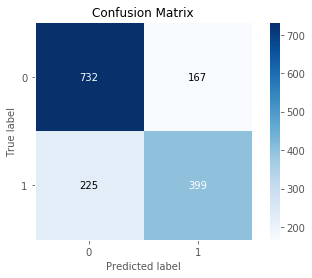

In [119]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on BOW

In [120]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.8930456950097002


In [121]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7426132632961261

In [122]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.010415,0.007365,0.010414,0.007364,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.506561,0.502566,0.502999,0.504042,0.001790,25,0.507156,0.504625,0.508475,0.506752,0.001598
1,0.031243,0.000005,0.013271,0.003320,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.538405,0.525916,0.554507,0.539609,0.011703,21,0.544167,0.536555,0.561285,0.547336,0.010341
2,0.075036,0.007076,0.004038,0.004353,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.568865,0.544521,0.585138,0.566175,0.016691,19,0.583435,0.566311,0.585955,0.578567,0.008727
3,0.264095,0.012467,0.030927,0.000985,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.699696,0.684493,0.705461,0.696550,0.008845,11,0.747019,0.729297,0.728926,0.735081,0.008443
4,0.524123,0.019698,0.054720,0.004245,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.739227,0.737021,0.753759,0.743336,0.007425,9,0.782307,0.787087,0.794759,0.788051,0.005129


C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



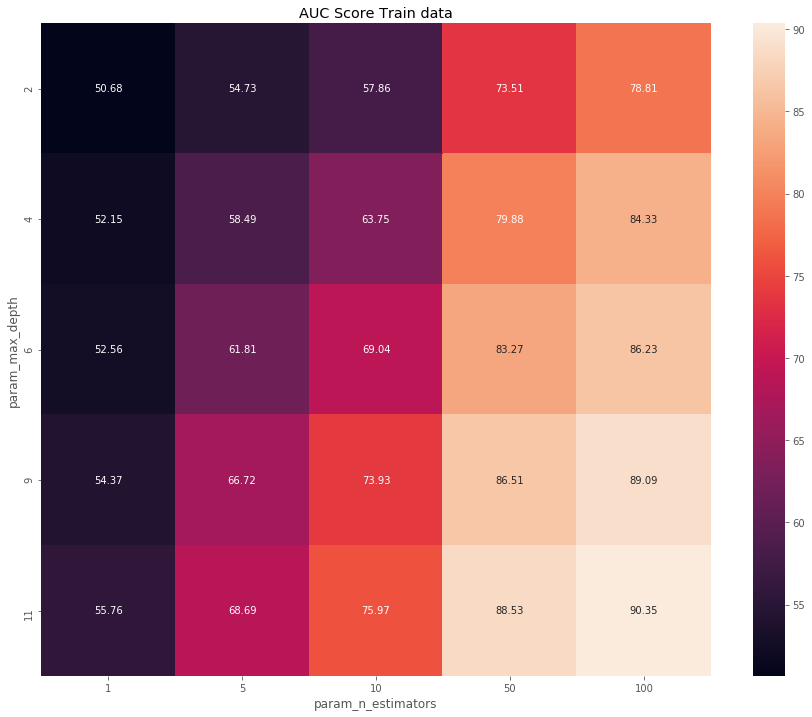

In [123]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



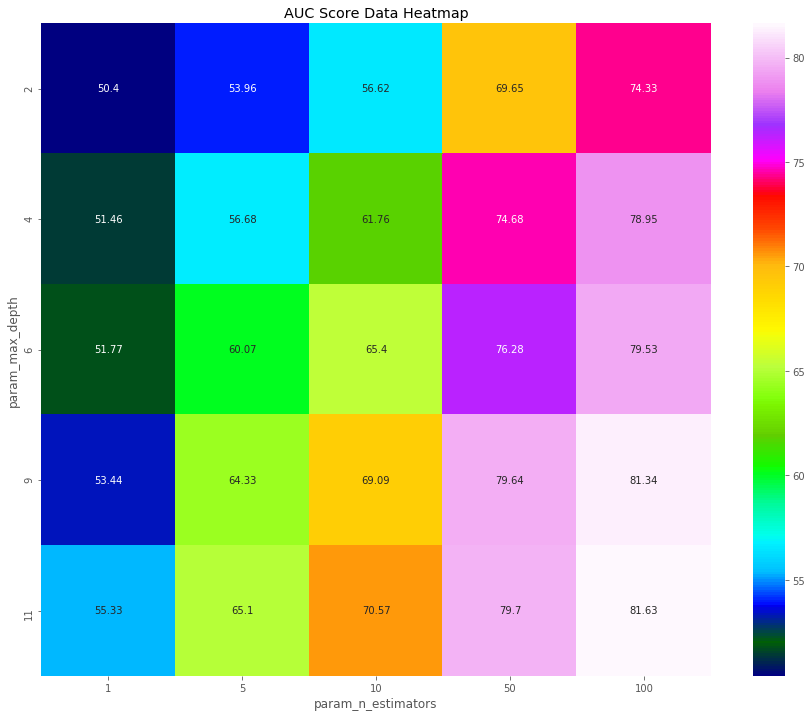

In [124]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  70.94652890676251


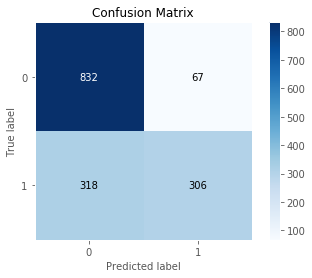

In [125]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [126]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

79.12015758371635


In [127]:
test_pred = rf.predict(test_BOW)

In [128]:
test_pred = rf.predict(test_BOW)
submission['target'] = test_pred.astype(int)
submission.to_csv('submission02.csv', index=False)

In [129]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.613117,0.018606,0.030373,0.005570,2,{'max_depth': 2},0.566502,0.566502,0.569787,0.566502,...,0.569787,0.565773,0.568874,0.569604,0.566867,0.565408,0.569604,0.568874,0.567926,0.001789
1,0.844871,0.028819,0.028624,0.001842,4,{'max_depth': 4},0.581281,0.584565,0.587849,0.584565,...,0.582740,0.586572,0.591498,0.586572,0.585112,0.591133,0.583288,0.588396,0.586426,0.002916
2,1.090483,0.021027,0.029426,0.003405,6,{'max_depth': 6},0.612479,0.609195,0.602627,0.610837,...,0.610108,0.605546,0.618683,0.616858,0.614851,0.610473,0.608466,0.609195,0.611604,0.003943
3,1.409830,0.028072,0.030020,0.004916,8,{'max_depth': 8},0.648604,0.627258,0.619048,0.627258,...,0.632549,0.627805,0.639117,0.637475,0.634373,0.641671,0.629447,0.632184,0.634410,0.004365
4,1.654475,0.019108,0.029222,0.002891,10,{'max_depth': 10},0.668309,0.638752,0.635468,0.650246,...,0.653713,0.646232,0.656085,0.653530,0.648604,0.655355,0.648969,0.652436,0.650629,0.004122


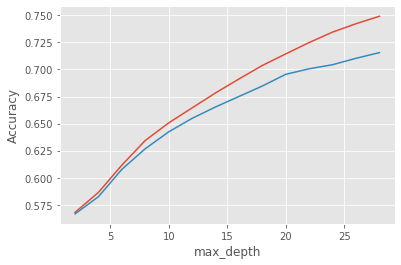

In [130]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [131]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 450}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.631206,0.127848,0.095923,0.004572,50,{'n_estimators': 50},0.794745,0.784893,0.782430,0.773399,...,0.781445,0.008347,8,0.987890,0.989737,0.988300,0.988506,0.988506,0.988588,0.000617
1,27.384414,0.362522,0.189926,0.007460,100,{'n_estimators': 100},0.798851,0.779967,0.774220,0.770936,...,0.778654,0.010737,9,0.989943,0.991379,0.988711,0.989737,0.989327,0.989819,0.000886
2,41.635087,0.706470,0.282766,0.011235,150,{'n_estimators': 150},0.797209,0.789819,0.771757,0.775862,...,0.782759,0.009384,7,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
3,54.535488,0.597164,0.371323,0.006867,200,{'n_estimators': 200},0.798851,0.787356,0.775862,0.779146,...,0.784072,0.008308,6,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
4,68.074456,0.783030,0.464804,0.008076,250,{'n_estimators': 250},0.801314,0.784072,0.782430,0.778325,...,0.785057,0.008395,3,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845


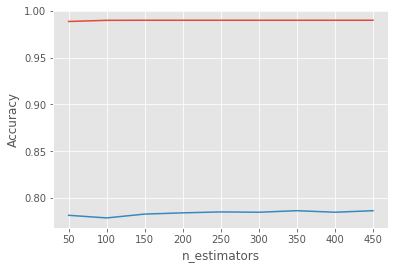

In [132]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [133]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.419690,0.082845,0.024491,0.006040,30,{'min_samples_leaf': 30},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
1,0.336462,0.040953,0.027401,0.004313,80,{'min_samples_leaf': 80},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
2,0.303926,0.015297,0.028110,0.006263,130,{'min_samples_leaf': 130},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
3,0.308360,0.016844,0.037495,0.007654,180,{'min_samples_leaf': 180},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
4,0.397076,0.097251,0.032084,0.007010,230,{'min_samples_leaf': 230},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101


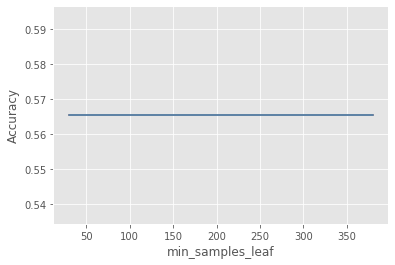

In [134]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [135]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.425464,0.340172,0.256477,0.022901,10,{'min_samples_split': 10},0.795567,0.787356,0.790640,0.782430,...,0.790640,0.005396,1,0.967159,0.966133,0.966954,0.967159,0.969007,0.967282,0.000941
1,25.918745,3.783656,0.278215,0.040965,60,{'min_samples_split': 60},0.788998,0.784072,0.776683,0.781609,...,0.784236,0.004854,7,0.936782,0.939860,0.939860,0.940476,0.942734,0.939943,0.001902
2,26.565551,3.043212,0.257248,0.043377,110,{'min_samples_split': 110},0.797209,0.786535,0.784893,0.782430,...,0.788342,0.005177,2,0.927135,0.931445,0.932061,0.933703,0.930213,0.930911,0.002198
3,23.809427,0.244336,0.254523,0.064498,160,{'min_samples_split': 160},0.786535,0.785714,0.783251,0.779967,...,0.783087,0.002767,8,0.930829,0.933498,0.930213,0.928571,0.929392,0.930501,0.001681
4,22.669571,0.166106,0.216516,0.070062,210,{'min_samples_split': 210},0.795567,0.784893,0.774220,0.779146,...,0.785057,0.007796,5,0.932882,0.929803,0.928777,0.931650,0.933908,0.931404,0.001896


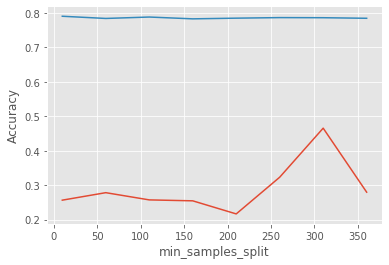

In [136]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [137]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 10}
Best parameter for n_estimators:  {'n_estimators': 450}


In [149]:
new_rf = RandomForestClassifier(n_estimators = 450 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 10)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.02823374917925


## GBDT on BOW

In [139]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [140]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.285637,0.135791,0.005187,0.000978,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,16.734266,1.600146,0.007980,0.004592,0.01,{'learning_rate': 0.01},0.629721,0.633826,0.615764,0.639573,0.614122,0.626601,0.010034,4
2,19.348034,0.272816,0.008178,0.006063,0.1,{'learning_rate': 0.1},0.741379,0.721675,0.740558,0.729064,0.740558,0.734647,0.007933,3
3,16.859045,1.233145,0.007641,0.003519,1,{'learning_rate': 1.0},0.761905,0.761905,0.760263,0.770936,0.755337,0.762069,0.005045,2
4,14.194008,1.909529,0.004189,0.001163,1.3,{'learning_rate': 1.3},0.761905,0.770936,0.754516,0.770936,0.756979,0.763054,0.006861,1


In [141]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [142]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.285637,0.135791,0.005187,0.000978,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,16.734266,1.600146,0.007980,0.004592,0.01,{'learning_rate': 0.01},0.629721,0.633826,0.615764,0.639573,0.614122,0.626601,0.010034,4
2,19.348034,0.272816,0.008178,0.006063,0.1,{'learning_rate': 0.1},0.741379,0.721675,0.740558,0.729064,0.740558,0.734647,0.007933,3
3,16.859045,1.233145,0.007641,0.003519,1,{'learning_rate': 1.0},0.761905,0.761905,0.760263,0.770936,0.755337,0.762069,0.005045,2
4,14.194008,1.909529,0.004189,0.001163,1.3,{'learning_rate': 1.3},0.761905,0.770936,0.754516,0.770936,0.756979,0.763054,0.006861,1


In [151]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 1.3)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

77.34734077478662


AUC =  75.98337540286929


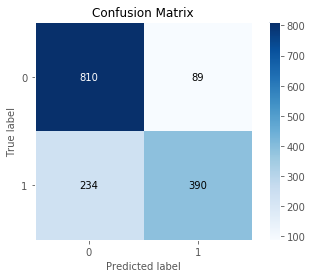

In [154]:
#print("***Test Data Report***")
#print("Best max_depth = ",optimal_depth)
#print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, GBC.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## XGB on BOW

In [144]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

78.00393959290874


In [153]:
max_depths = [2,4,6,9,11,15,20]
base_learners = [1, 5, 10, 50, 100 , 200 , 300]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.9278254494015058


***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  70.94652890676251


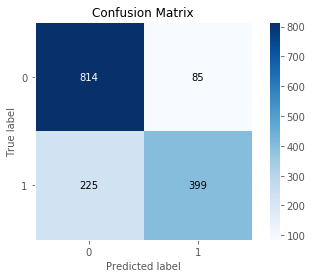

In [157]:
xg_model = xgb.XGBClassifier(max_depth=20, n_estimators=50, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [ ]:
# test_pred = xg_model.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission04xgb.csv', index=False)